In [66]:
%matplotlib inline

In [67]:
from main import *
import numpy as np

In [68]:
q1 = Quadratic(
    np.array([[1, 0], [0, 1]]),
    np.array([1, 1]),
    -1.4
)

q2 = Quadratic(
    np.array([[0.1, 0], [0, 3]]),
    np.array([0, 0]),
    0
)  # Dichotomy is much better

q3 = Quadratic(
    np.array([[4, 0], [0, 1]]),
    np.array([-1, 2]),
    1.5
)


def mf1(x, y):
    term1 = np.sin(x) * np.cos(y)
    term2 = -1.0 * np.exp(-(x**2 + y**2)/10)
    term3 = 0.1 * (x**2 + y**2)
    return term1 + term2 + term3


def mf2(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


def mf3(x, y):
    term2 = -1.0 * np.exp(-(x**2 + y**2)/10)
    return term2


def mf4(x, y):
    return (x**2 - 1)**2 + y**2 + 0.5 * x


def mf5(x, y):
    return (x**2 - 1)**2 + y**2


f1 = BiFuncCallableWrapper(mf1)
f2 = BiFuncCallableWrapper(mf2)
f3 = BiFuncCallableWrapper(mf3)
f4 = BiFuncCallableWrapper(mf4)  # TOP 1
f5 = BiFuncCallableWrapper(mf5)

In [69]:
# q1, q2
# 3 LRS (2 типа h, разные гиперпараметры), Dichotomy, Armijo * 2 (x_0)

func = BiFuncStatsDecorator(q2)
x_0 = np.array([1, 1])
# x_01 = np.array([0.0, 0.0])
# x_02 = np.array([1.0, 4.0])
# x_03 = np.array([1.0, 1.0])
# x_0_array = [x_01, x_02, x_03]
# h_array = [constant_h(0.1), exponential_decay(0.5), exponential_decay(0.3)]
# func_array = [BiFuncStatsDecorator(q1), BiFuncStatsDecorator(q2)]
PLOT_SIZE=3

In [70]:
import matplotlib.pyplot as plt


def plot_trajectory(func: BiFunc, trajectory: np.ndarray, title=None):
    # Create a meshgrid for the 3D plot
    x = np.linspace(-PLOT_SIZE, PLOT_SIZE, 100)
    y = np.linspace(-PLOT_SIZE, PLOT_SIZE, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    # Plot the 3D surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)  # type: ignore

    # Plot the trajectory
    ax.plot(trajectory[:, 0], trajectory[:, 1], [func(np.array([x, y]))
            for x, y in trajectory], color='r', marker='o')

    if title:
        ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')  # type: ignore
    #ax.set_zlim(-2, 20)
    plt.show()

In [71]:
def print_stats(func: BiFuncStatsDecorator, trajectory: np.ndarray, title=None):
    cc, gc = func.call_count, func.gradient_count
    print(f'Iterations: {len(trajectory) - 1}')
    print(f'x: {trajectory[-1]} f(x): {func(trajectory[-1])}')
    print(f'Function evaluations: {cc}')
    print(f'Gradient evaluations: {gc}')
    plot_trajectory(func, trajectory, title)
    func.reset()

In [72]:
def relative_x_condition(x: np.ndarray, prev: np.ndarray) -> bool:
    # ‖𝑥_{𝑘+1} − 𝑥_𝑘‖ < 𝜀(‖𝑥_{𝑘+1}‖ + 1)
    eps = 1e-9
    return bool(np.linalg.norm(x - prev) < eps * (np.linalg.norm(x) + 1))

def relative_f_condition_ctor(func: BiFunc):
    def f(x: np.ndarray, prev: np.ndarray) -> bool:
        # ‖∇𝑓(𝑥_𝑘)‖^2 < 𝜀‖∇𝑓(𝑥_0)‖^2
        eps = 1e-9
        return bool(np.linalg.norm(func.gradient(x) ** 2) < eps * np.linalg.norm(func.gradient(x_0)) ** 2)
    return f

In [73]:
# from scipy.optimize import fmin_cg
# eps = 1e-9
# stat_array = []
# for func in func_array:
#     for x_0 in x_0_array:
#         lrs_array = [] 
#         for h in h_array:
#             lrs_array.append((learning_rate_scheduling(x_0, func, h, relative_x_condition)))

#         stat_array.append((x_0, func, (
#                                         lrs_array,
#                                         [steepest_gradient_descent_armijo(x_0, func, relative_x_condition)],
#                                         [steepest_gradient_descent_dichotomy(x_0, func, eps, relative_x_condition)]
#                                         )))
        
# alg_name_array = ["Learning rate scheduling", "Armijo Gradient Descent", "Dichotomy Gradient Descent"]
# h_name_array = ["constant_h(0.1)", "exponential_decay(0.5)", "exponential_decay(0.3)"]

# def print_stat(index: int):
#     h = ""
#     for stat in stat_array:
#         x_0 = stat[0]
#         func = stat[1]
#         trajectory_array = stat[2][index]
#         for trajectory_index in range(len(trajectory_array)):
#             if (index == 0):
#                 h = h_name_array[trajectory_index]
#             fmin_cg(
#                 func,
#                 x_0,
#                 func.gradient,
#                 disp=True
#             )
#             print_stats(func, trajectory_array[trajectory_index], alg_name_array[index] + f' x0={x_0} {h}')
#     print("-------------------------------------------------------------------")
    
# print_stat(0)
# print_stat(1)
# print_stat(2)

Iterations: 6994
x: [8.38447139e-07 5.18611482e-09] f(x): 7.038004779672595e-14
Function evaluations: 0
Gradient evaluations: 6994


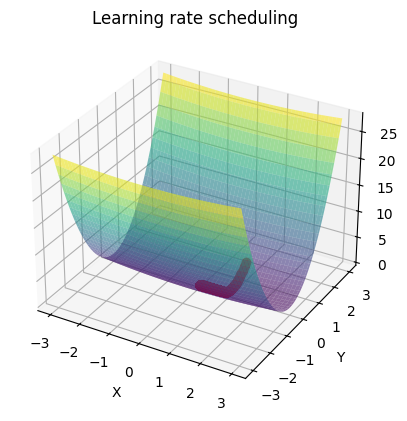

In [74]:
h = exponential_decay(0.5)
h = polynomial_decay(0.5, 1)
h = geometric_h()
h = constant_h(0.01)

trajectory = learning_rate_scheduling(x_0, func, h, relative_x_condition)
print_stats(func, trajectory, "Learning rate scheduling")

Iterations: 13
x: [ 1.29903633e-07 -4.39183014e-09] f(x): 1.745359894025873e-15
Function evaluations: 725
Gradient evaluations: 13


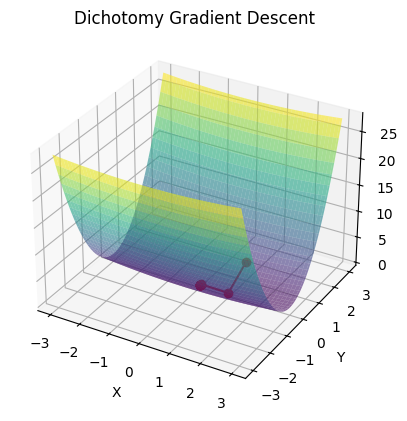

In [75]:
eps = 1e-9
trajectory = steepest_gradient_descent_dichotomy(
    x_0, func, eps, relative_x_condition)
print_stats(func, trajectory, "Dichotomy Gradient Descent")

Iterations: 1419
x: [ 4.30957764e-06 -1.80797919e-09] f(x): 1.8572557532909115e-12
Function evaluations: 24823
Gradient evaluations: 1419


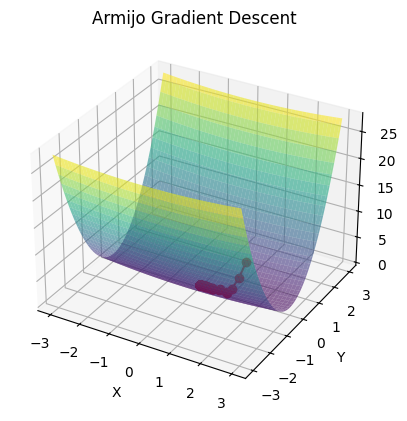

In [76]:
trajectory = steepest_gradient_descent_armijo(x_0, func, relative_x_condition)
print_stats(func, trajectory, "Armijo Gradient Descent")

Iterations: 191
x: [-4.08250994e-08 -2.11258755e-09] f(x): 1.8005795261696888e-16
Function evaluations: 325817
Gradient evaluations: 120183


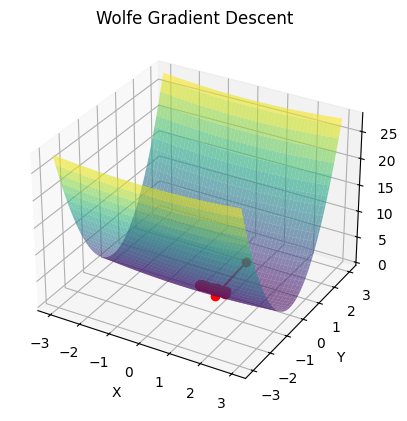

In [77]:
trajectory = steepest_gradient_descent_wolfe(x_0, func, relative_x_condition)
print_stats(func, trajectory, "Wolfe Gradient Descent")

In [78]:
from scipy.optimize import fmin_cg

# Conjugate Gradient Descent, similar to steepest GD
fmin_cg(
    func,
    x_0 - 0.1,
    func.gradient,
    disp=True
)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


array([-2.66453526e-15,  1.08094957e-16])